In [4]:
from snorkel.labeling import labeling_function,PandasLFApplier
import snorkel
import re
import numpy as np
import torch

In [5]:
from datasets import load_dataset

dataset = load_dataset("eli5")

Found cached dataset eli5 (C:/Users/Don Jaekle/.cache/huggingface/datasets/eli5/LFQA_reddit/1.0.0/17574e5502a10f41bbd17beba83e22475b499fa62caa1384a3d093fc856fe6fa)


  0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
import pandas as pd

In [3]:
df = pd.DataFrame(dataset["train_eli5"])

KeyboardInterrupt: 

In [7]:
dataset["train_eli5"] = dataset["train_eli5"].filter(lambda example: example["answers"]['score'][0]>10)

Loading cached processed dataset at C:\Users\Don Jaekle\.cache\huggingface\datasets\eli5\LFQA_reddit\1.0.0\17574e5502a10f41bbd17beba83e22475b499fa62caa1384a3d093fc856fe6fa\cache-4ca265bf51d112e2.arrow


In [86]:
dataset["train_eli5"]

Dataset({
    features: ['q_id', 'title', 'selftext', 'document', 'subreddit', 'answers', 'title_urls', 'selftext_urls', 'answers_urls'],
    num_rows: 68387
})

In [87]:
corpus = dataset["train_eli5"]["answers"]
corpus = [item['text'][0] for item in corpus]
corpus = [item for item in corpus if (len(item) > 100 and isinstance(item,str))]

In [88]:
df = pd.DataFrame(corpus, columns =["text"])
df.head()

,text
0,"Two things going on here. First, heat doesn't..."
1,It's mostly due to the difference in immune sy...
2,"It has to include equipment, pay for employees..."
3,While not universally true (especially in the ...
4,The passive type of jug won't filter out bacte...


In [89]:
#now witha  corpus we can apply flagging functions

In [115]:
#first lets work with materials from common core- these rules seem really lackluster but theyre easily implemented.

ABSTAIN = -1
CandE = 0
Classification = 1
Comparison = 2
Definition = 3
Description = 4
PandS = 5
Sequence = 6

CandE_list = ["reason","why","as a result", "therefore", "because","due to"]
CandE_re = re.compile("|".join(CandE_list))

Classification_list = ["most significant", "least significant", "characteristics","classify","classification"]
Classification_re = re.compile("|".join(Classification_list))

Comparison_list = ["alike","similar","differing","different","contrast","compare","although"]
Comparison_re = re.compile("|".join(Comparison_list))

Definition_list = ["define","meaning","synonymous with","defition","such as","characterized as"]
Definition_re = re.compile("|".join(Definition_list))


Description_list = ["illustrate","describe", "taste","tastes like","feel","appears","sounds like","smells like"]
Description_re = re.compile("|".join(Description_list))

PandS_list = ["problem","issue","solve","solution", "fix","cosequently"]
PandS_re = re.compile("|".join(PandS_list))

Sequence_list = ["first","next","finally","happened","before","after"]
Sequence_re = re.compile("|".join(Sequence_list))


In [116]:
@labeling_function()
def lf_keyword_CandE(x):
    return CandE if CandE_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_Classification(x):
    return Classification if Classification_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_Comparison(x):
    return Comparison if Comparison_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_Definition(x):
    return Definition if Definition_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_Description(x):
    return Description if Description_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_PandS(x):
    return PandS if PandS_re.search(x.text.lower()) else ABSTAIN

@labeling_function()
def lf_keyword_Sequence(x):
    return Sequence if Sequence_re.search(x.text.lower()) else ABSTAIN



In [117]:
lfs = [lf_keyword_CandE,
       lf_keyword_Classification,
       lf_keyword_Comparison,
       lf_keyword_Definition,
       lf_keyword_Description,
       lf_keyword_PandS,
       lf_keyword_Sequence]

In [118]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df)

100%|██████████████████████████████████████████████████████████████████████████| 66028/66028 [00:09<00:00, 6606.15it/s]


In [107]:
L_train

array([[ 1, -1, -1, ..., -1, -1,  7],
       [ 1, -1, -1, ..., -1, -1,  7],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1]])

In [108]:
coverage_CandE,coverage_Classification,coverage_Comparison,coverage_Definition,coverage_Description,coverage_PandS,coverage_Sequence = (L_train != ABSTAIN).mean(axis=0)
print(f"CandE coverage: {coverage_CandE * 100:.1f}%")
print(f"Classification coverage: {coverage_Classification * 100:.1f}%")
print(f"Comparison coverage: {coverage_Comparison* 100:.1f}%")
print(f"Definition coverage: {coverage_Definition * 100:.1f}%")
print(f"Description coverage: {coverage_Description * 100:.1f}%")
print(f"PandS coverage: {coverage_PandS * 100:.1f}%")
print(f"Sequence coverage: {coverage_Sequence * 100:.1f}%")


CandE coverage: 44.1%
Classification coverage: 0.5%
Comparison coverage: 20.3%
Definition coverage: 7.9%
Description coverage: 10.9%
PandS coverage: 13.8%
Sequence coverage: 26.2%


In [109]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_keyword_CandE,0,[1],0.440646,0.273414,0.273414
lf_keyword_Classification,1,[2],0.005392,0.004695,0.004695
lf_keyword_Comparison,2,[3],0.203368,0.158296,0.158296
lf_keyword_Definition,3,[4],0.079209,0.064685,0.064685
lf_keyword_Description,4,[5],0.108621,0.087614,0.087614
lf_keyword_PandS,5,[6],0.137684,0.110332,0.110332
lf_keyword_Sequence,6,[7],0.262374,0.195705,0.195705


In [110]:
L_train

array([[ 1, -1, -1, ..., -1, -1,  7],
       [ 1, -1, -1, ..., -1, -1,  7],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1, -1, -1, ..., -1, -1, -1]])

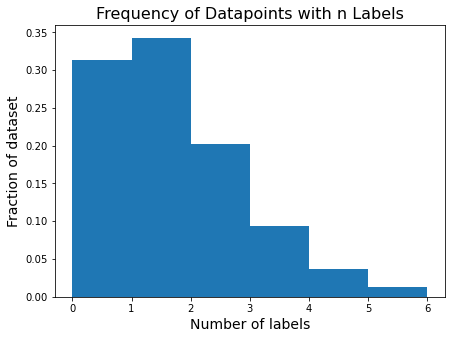

In [234]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.figure(figsize=[7,5])
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.title("Frequency of Datapoints with n Labels",fontsize = 16)
    plt.xlabel("Number of labels",fontsize = 14)
    plt.ylabel("Fraction of dataset",fontsize = 14)
    plt.savefig("frequency.png",dpi = 300)


plot_label_frequency(L_train)

In [119]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=8, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)


INFO:root:Computing O...
INFO:root:Estimating \mu...
 59%|████████████████████████████████████████████▊                               | 295/500 [00:00<00:00, 987.59epoch/s]INFO:root:[300 epochs]: TRAIN:[loss=0.001]
INFO:root:[400 epochs]: TRAIN:[loss=0.000]
100%|███████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1014.19epoch/s]
INFO:root:Finished Training


In [120]:
probs_train = label_model.predict_proba(L_train)
probs_train

array([[0.31899793, 0.01148197, 0.12236013, ..., 0.07631298, 0.38383266,
        0.01141455],
       [0.31899793, 0.01148197, 0.12236013, ..., 0.07631298, 0.38383266,
        0.01141455],
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
        0.125     ],
       ...,
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.125     , 0.125     , 0.125     , ..., 0.125     , 0.125     ,
        0.125     ],
       [0.284859  , 0.06759304, 0.13812884, ..., 0.1124483 , 0.14901545,
        0.06751525]])

In [121]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df, y=probs_train, L=L_train
)

In [195]:
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch


In [170]:
from typing import Callable, List, Optional, Tuple

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length,
                                                    truncation = True
                                                    )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [176]:
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_transformer = BertTransformer(tokenizer, bert_model)
encodings = bert_transformer.transform(df_train_filtered["text"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

In [178]:
encodings.shape

torch.Size([45376, 768])

In [180]:
len(encodings[0])

768

In [188]:
probs_train_filtered.shape

(45376, 8)

(66028, 8)

In [192]:
max_probs = np.zeros_like(probs_train_filtered)
max_probs[np.arange(len(probs_train_filtered)), probs_train_filtered.argmax(1)] = 1


In [205]:
y = np.argmax(probs_train_filtered,axis = 1)
len(y)

45376

In [206]:
X = encodings

In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [208]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = .2,random_state = 10)

X_test, X_val,y_test,y_val = train_test_split(X_test,y_test,test_size = .5,random_state = 10)

In [209]:

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X_train,y_train)

RandomForestClassifier(n_jobs=1)

In [224]:
y_pred=model.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.5286029087703834


In [213]:
y_test

array([2, 2, 4, ..., 2, 0, 2], dtype=int64)

In [215]:
nums, counts= np.unique(y_test, return_counts=True)

In [220]:
print(f"baseline_accuracy:{max(counts/sum(counts))}")

baseline_accuracy:0.40304098721903925


In [221]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.83324221, 0.15481986, 0.        , 0.        , 0.        ,
       0.21180275])

In [222]:
matrix

array([[1524,  120,    0,    0,    0,  185],
       [ 742,  159,    0,    0,    0,  126],
       [  73,   18,    0,    0,    0,   15],
       [ 120,   16,    0,    0,    0,   21],
       [ 157,    9,    0,    0,    0,   16],
       [ 898,   77,    0,    0,    0,  262]], dtype=int64)

In [231]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
val_scores = []
train_scores =[]
best_score = 0
best_n = 0
for n in [100,120,150]:
    forest= RandomForestClassifier(n_estimators =n, random_state = 0)
    forest.fit(X_train, y_train)
    val_prediction = forest.predict(X_val)
    train_prediction = forest.predict(X_train)
    val_score = accuracy_score(y_val,val_prediction)
    train_score = accuracy_score(y_train,train_prediction)
    train_scores.append(train_score)
    val_scores.append(val_score)
    if val_score > best_score:
        best_score = val_score
        best_n = n

ValueError: x and y must have same first dimension, but have shapes (149,) and (3,)

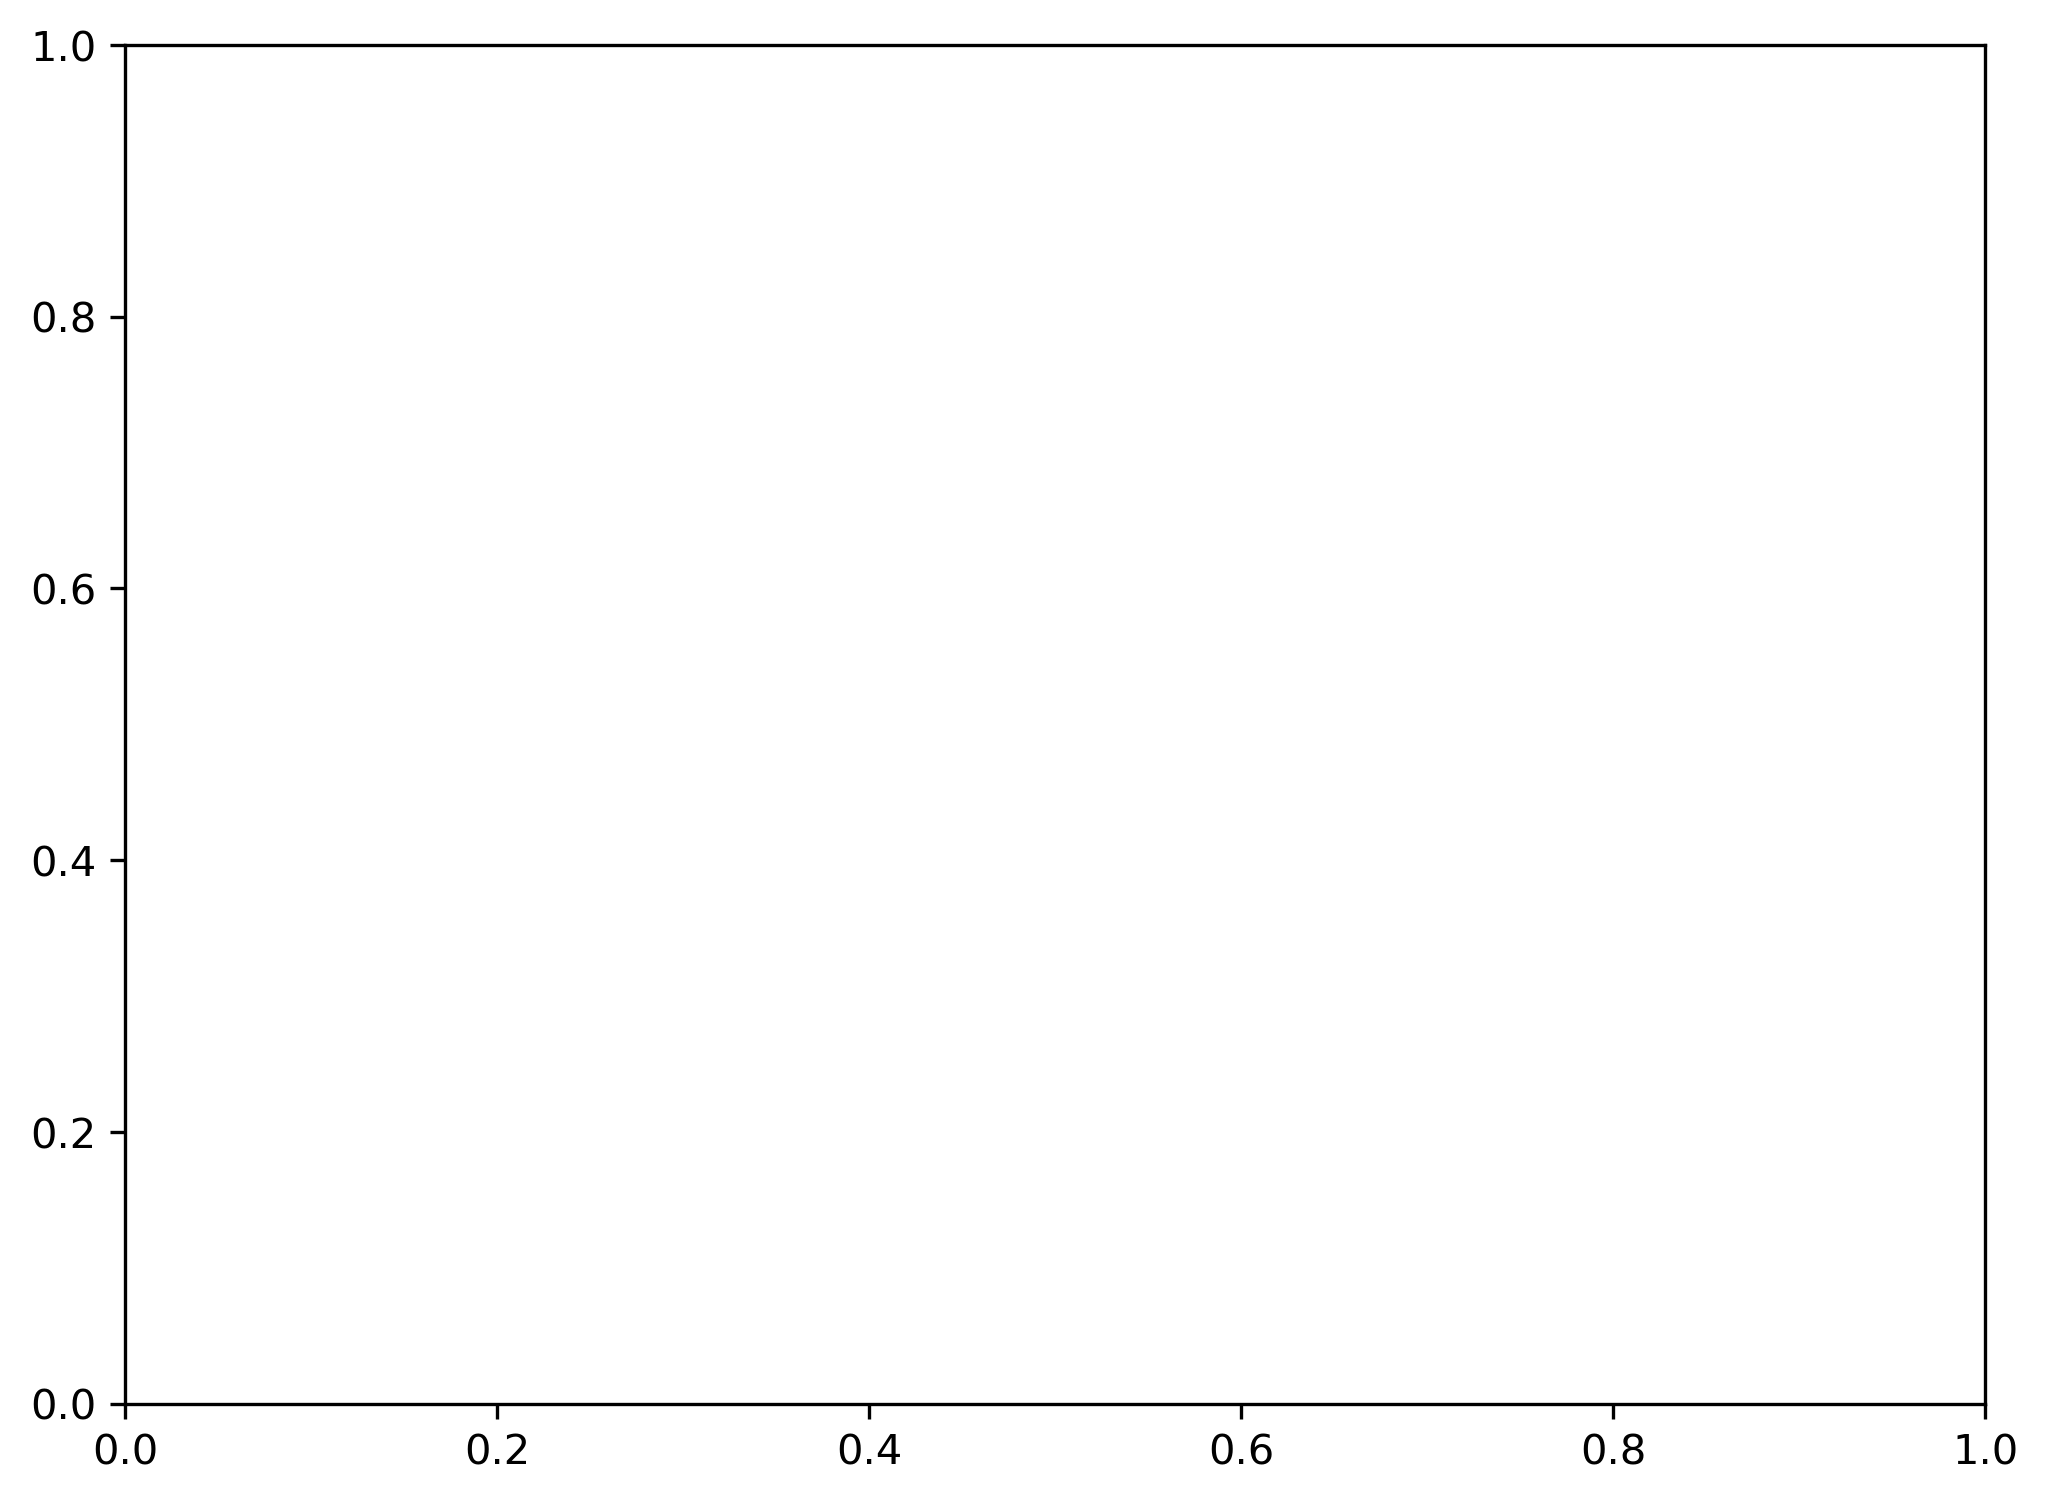

In [232]:
plt.figure(figsize=(8,6), dpi=300)
plt.plot(range(1,150), val_scores, label= "val score")
plt.plot(best_n, best_score, "o", color = "red", label = f"best n = {best_n}")
plt.plot(range(1,150),train_scores, label = "train score")
plt.legend()
plt.title("Random forest model recall")
plt.xlabel("n neighbors")
plt.ylabel("Recall Score")
plt.savefig(f"../figures/random_forest_recall.png",bbox_inches="tight", dpi = 300)
plt.show()

In [226]:
from sklearn.svm import SVC
from sklearn.svm import SVR
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = np.logspace(-3,3,3)
degree_values = [3,8]
coef0_values = [0.01,10,0.5]
gamma_values = ['auto','scale']

model=SVC()
grid_search=GridSearchCV(estimator=model,param_grid=grid,cv=3)
grid_result = grid_search.fit(X_train,y_train)
    
clf = SVC(C = grid_result.best_params_['C'],
    coef0 = grid_result.best_params_['coef0'],
    degree = grid_result.best_params_['degree'],
    gamma = grid_result.best_params_['gamma'],
    kernel = grid_result.best_params_['kernel'])
clf.fit(df_train_imp,y_train)
y_pred = clf.predict(df_test_imp)

NameError: name 'GridSearchCV' is not defined

In [32]:
dataset = load_dataset("eli5")
df = pd.DataFrame(dataset["train_eli5"])

Found cached dataset eli5 (C:/Users/Don Jaekle/.cache/huggingface/datasets/eli5/LFQA_reddit/1.0.0/17574e5502a10f41bbd17beba83e22475b499fa62caa1384a3d093fc856fe6fa)


  0%|          | 0/9 [00:00<?, ?it/s]

In [33]:
df.head()

,q_id,title,selftext,document,subreddit,answers,title_urls,selftext_urls,answers_urls
0,1oy5tc,in football whats the point of wasting the fir...,,,explainlikeimfive,"{'a_id': ['ccwtgnz', 'ccwtmho', 'ccwt946', 'cc...",{'url': []},{'url': []},{'url': []}
1,2lojul,Why are different tiers (regular < mid < premi...,I've noticed that the difference in price betw...,,explainlikeimfive,"{'a_id': ['clwqgxl', 'clwqpjq', 'clwuh3s'], 't...",{'url': []},{'url': []},{'url': []}
2,8v5e3s,Stars and Visibility,Why do stars in the night's sky seem to disapp...,,explainlikeimfive,"{'a_id': ['e1kpw6u'], 'text': ['It's a quirk o...",{'url': []},{'url': []},{'url': []}
3,1v3wij,How do we know all the money the government is...,We hear about these large billion dollar bank ...,,explainlikeimfive,"{'a_id': ['ceohakd', 'ceoikhs', 'ceoji15', 'ce...",{'url': []},{'url': ['http://dealbook.nytimes.com/2014/01/...,{'url': ['http://www.reuters.com/article/2013/...
4,2jlp6f,What are good and bad sides of manual and auto...,Please consider I'm not a driver. Automatic se...,,explainlikeimfive,"{'a_id': ['clcur3j'], 'text': ['Automatics wei...",{'url': []},{'url': []},{'url': []}


In [34]:
x = df["answers"][0]

In [35]:
def fix(dictionary):
    return [dict(zip(dictionary,t)) for t in zip(*dictionary.values())]
df["answers"] = df["answers"].apply(fix)



In [36]:
df

,q_id,title,selftext,document,subreddit,answers,title_urls,selftext_urls,answers_urls
0,1oy5tc,in football whats the point of wasting the fir...,,,explainlikeimfive,"[{'a_id': 'ccwtgnz', 'text': 'Keep the defense...",{'url': []},{'url': []},{'url': []}
1,2lojul,Why are different tiers (regular < mid < premi...,I've noticed that the difference in price betw...,,explainlikeimfive,"[{'a_id': 'clwqgxl', 'text': 'As someone who u...",{'url': []},{'url': []},{'url': []}
2,8v5e3s,Stars and Visibility,Why do stars in the night's sky seem to disapp...,,explainlikeimfive,"[{'a_id': 'e1kpw6u', 'text': 'It's a quirk of ...",{'url': []},{'url': []},{'url': []}
3,1v3wij,How do we know all the money the government is...,We hear about these large billion dollar bank ...,,explainlikeimfive,"[{'a_id': 'ceohakd', 'text': 'I'm pretty confi...",{'url': []},{'url': ['http://dealbook.nytimes.com/2014/01/...,{'url': ['http://www.reuters.com/article/2013/...
4,2jlp6f,What are good and bad sides of manual and auto...,Please consider I'm not a driver. Automatic se...,,explainlikeimfive,"[{'a_id': 'clcur3j', 'text': 'Automatics weigh...",{'url': []},{'url': []},{'url': []}
...,...,...,...,...,...,...,...,...,...
272629,ckfrwx,Do we all see the same color or my red can be ...,[removed],,explainlikeimfive,"[{'a_id': 'evmzhep', 'text': 'Most likely that...",{'url': []},{'url': []},{'url': []}
272630,ckfv7s,what does that often blue tape that athletes p...,,,explainlikeimfive,"[{'a_id': 'evmvuxf', 'text': 'It's called Kine...",{'url': []},{'url': []},{'url': []}
272631,ckg0co,"If cells die of age, where do new ones come from?",Cells tend to die after dividing for a certain...,,explainlikeimfive,"[{'a_id': 'evmx5tu', 'text': 'That gets a bit ...",{'url': []},{'url': []},{'url': []}
272632,ckgagf,why the future of the planet depends on saving...,"I don’t understand, honestly thought they just...",,explainlikeimfive,"[{'a_id': 'evn0fnd', 'text': 'Why are they imp...",{'url': []},{'url': []},{'url': []}


In [37]:
df = df.explode("answers")

In [38]:
def filter_func(answer):
    if len(answer["text"]) > 100 and answer["score"] > 10:
        return True
    return False

In [39]:
df = df[df["answers"].apply(filter_func)]

In [40]:
df["answers"] = df["answers"].apply(lambda x: x["text"])

In [28]:
df2 = pd.DataFrame

In [44]:
def filter_func(x):
    if len(x) == 0:
        return True
    return False
df = df[df["selftext"].apply(filter_func)]

In [46]:
df.to_csv("raw_data.csv")